# Spatial plots of tas/pr post Krakatoa eruption using CMIP6 historical model output
- opens all CMIP6 historical model run files with data on precipitation pr and surface temperature tas 
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- generates spatial plots at 4 discrete times following Krakatoa 1883 (Aug 1883, Feb 1884, Aug 1884, Aug 1885)

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
#import cmocean.cm as cmo # package with a nice colourbar for rainfall 

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/pr/gr1.5

v20200302  v20201227


In [4]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
print(institution_dir, tas_dir, pr_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/


## Read in model data

In [5]:
models_tas = funcM.read_models(institution_dir, tas_dir, '1850-01','2015-01')

53 model paths found and loaded into the dictionary "models"
53 models have been successfully loaded into an xarray


In [6]:
models_pr = funcM.read_models(institution_dir, pr_dir, '1850-01','2015-01')

52 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
51 models have been successfully loaded into an xarray


In [7]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [8]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units
models['pr'] = models.pr*86400
models

,Array,Chunk
Bytes,10.83 GiB,1.32 MiB
Shape,"(51, 1980, 120, 240)","(1, 12, 120, 240)"
Count,43221 Tasks,8415 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,21.67 GiB,2.64 MiB
Shape,"(51, 1980, 120, 240)","(1, 12, 120, 240)"
Count,42229 Tasks,8415 Chunks
Type,float64,numpy.ndarray


In [9]:
models = models.sel(model= ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1',
                             'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
                             'CMCC-CM2-HR4', 'CMCC-CM2-SR5' ,'CanESM5', 'E3SM-1-1' ,'E3SM-1-1-ECA' ,'EC-Earth3', 
                             'EC-Earth3-AerChem' , 'EC-Earth3-Veg-LR', 'FGOALS-f3-L' ,'FGOALS-g3', 'FIO-ESM-2-0', 
                             'GFDL-CM4' ,'GFDL-ESM4', 'GISS-E2-1-G' ,'GISS-E2-1-G-CC', 'GISS-E2-1-H' ,'IITM-ESM', 
                             'INM-CM4-8', 'INM-CM5-0' ,'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6' ,'MPI-ESM-1-2-HAM',
                             'MPI-ESM1-2-LR' ,'MRI-ESM2-0', 'NESM3', 'NorCPM1' ,'NorESM2-LM', 'NorESM2-MM',
                             'SAM0-UNICON', 'TaiESM1'])
models

,Array,Chunk
Bytes,9.13 GiB,1.32 MiB
Shape,"(43, 1980, 120, 240)","(1, 12, 120, 240)"
Count,50316 Tasks,7095 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,18.27 GiB,2.64 MiB
Shape,"(43, 1980, 120, 240)","(1, 12, 120, 240)"
Count,49324 Tasks,7095 Chunks
Type,float64,numpy.ndarray


In [10]:
# # get rid of models with issues
# models = models.drop_sel(model=['CIESM'])

In [11]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out time around Krakatoa eruption

In [12]:
models = models.sel(time = slice('1850-01','1900-01'))

## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

In [14]:
# import land fraction data
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/Old_Models/landfraction_file_grid1.5.nc')
landmask = landfrac_ds.mean(dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-01-01 01:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 01:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axi

## Anomalies

In [15]:
# use functions to calculate the monthly anomalies for the globe and take the multi model mean 
K_mmm_s_Glob = func.seasonal_anomaly(models_w, '1850-01', '1881-01').mean(dim='model')

In [16]:
# select out regions for other anomalies 
K_mmm_s_SH = K_mmm_s_Glob.sel(lat=slice(-90,0)) 
K_mmm_s_NH = K_mmm_s_Glob.sel(lat=slice(0,90)) 
K_mmm_s_Aus = K_mmm_s_Glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.data==1, drop=True)
K_mmm_s_EA = K_mmm_s_Glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.data==1, drop=True)

## Figures

In [17]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

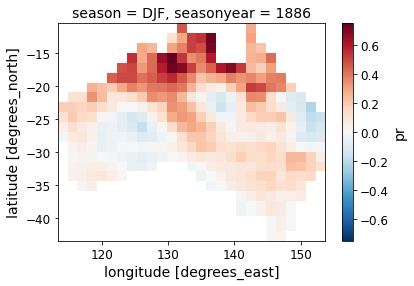

In [31]:
K_mmm_s_Aus.pr.sel(seasonyear=1886).sel(season='DJF').plot()

In [27]:
# dates and title for eruption and 3 times after
# K_dates winter
K_dates_w = [1883, 1884, 1885, 1886]
# K_dates_summer
K_dates_s = [1882, 1883, 1884, 1885]

In [35]:
# winter titles
titles_w = func.seasonal_title(K_dates_w, 'winter', 'JJA')
 # summer titles 
titles_s = func.seasonal_title(K_dates_s, 'summer', 'DJF')
titles_s

['summer prior to eruption, DJF 1882',
 '1st summer post-eruption, DJF 1883',
 '2nd summer post-eruption, DJF 1884',
 '3rd summer post-eruption, DJF 1885']

In [29]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [30]:
# set the mod max for the colour bars
cmax_tas = [-0.8,0.8]
cmax_pr = [-0.8,0.8]

In [23]:
# calculate std as calculated in the graphs
std_Glob = K_mmm_s_Glob.sel(seasonyear = slice('1850', '1881')).std(dim = ['seasonyear'])
std_Aus = K_mmm_s_Aus.sel(seasonyear = slice('1850', '1881')).std(dim = ['seasonyear'])
std_Aus

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 27, season: 4)
Coordinates:
  * lat      (lat) float64 -42.75 -41.25 -38.25 -36.75 ... -14.25 -12.75 -11.25
  * lon      (lon) float64 114.0 115.5 117.0 118.5 ... 148.5 150.0 151.5 153.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tas      (season, lat, lon) float64 dask.array<chunksize=(1, 21, 27), meta=np.ndarray>
    pr       (season, lat, lon) float64 dask.array<chunksize=(1, 21, 27), meta=np.ndarray>

In [27]:
# select out jja and djf seasons and put into a list for plotting
std_Glob_tas = [std_Glob.sel(season='JJA').tas, std_Glob.sel(season='DJF').tas]
std_Aus_tas= [std_Aus.sel(season='JJA').tas, std_Aus.sel(season='DJF').tas]

std_Glob_pr = [std_Glob.sel(season='JJA').pr, std_Glob.sel(season='DJF').pr]
std_Aus_pr = [std_Aus.sel(season='JJA').pr, std_Aus.sel(season='DJF').pr]

In [29]:
titles_Aus = ['Australia, JJA 1850-1880','Australia, DJF 1850-1880']
titles_std = ['Global, JJA 1850-1880','Global, DJF 1850-1880', 'Australia, JJA 1850-1880','Australia, DJF 1850-1880']

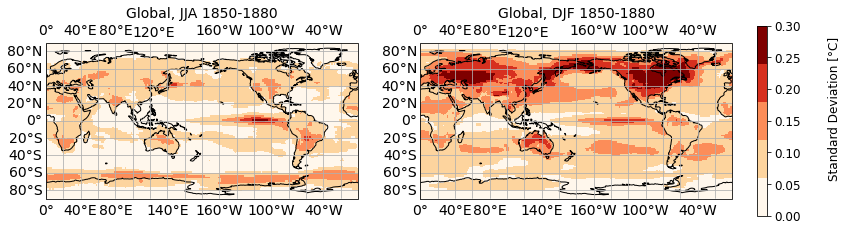

In [56]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
cmax_std = [0,0.3]
label_loc = [2.2, 0.06]
fig = fplot.std_plot(1, 2, std_Glob_tas, cmax_std, titles_std, 'OrRd', f'Standard Deviation [{deg}C]', label_loc)

fig.set_figwidth(15)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_std_tas_Glob.pdf', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


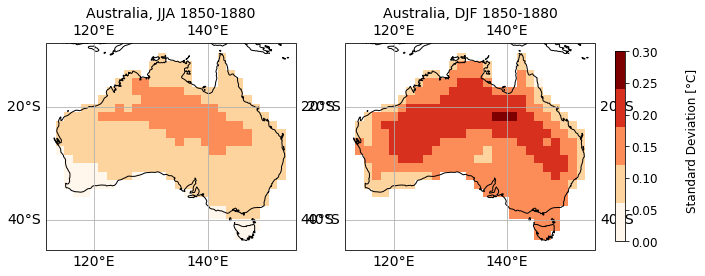

In [57]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
cmax_std = [0,0.3]
label_loc = [2.2, 0.05]
fig = fplot.std_plot(1, 2, std_Aus_tas, cmax_std, titles_Aus, 'OrRd', f'Standard Deviation [{deg}C]', label_loc)

fig.set_figwidth(12)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_std_tas_Aus.pdf', dpi=300, bbox_inches='tight')

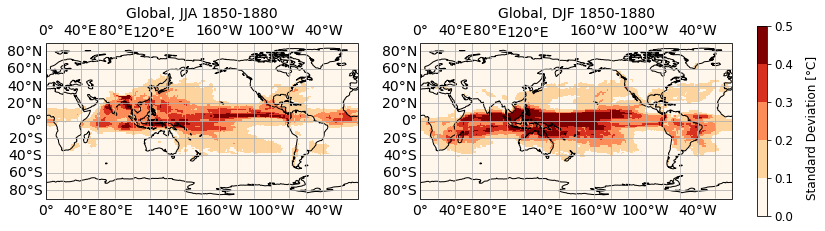

In [51]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
cmax_std = [0,0.5]
label_loc = [2.5, 0.05]
fig = fplot.std_plot(1, 2, std_Glob_pr, cmax_std, titles_std, 'OrRd', f'Standard Deviation [{deg}C]', label_loc)

fig.set_figwidth(15)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_std_pr_Glob.pdf', dpi=300, bbox_inches='tight')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


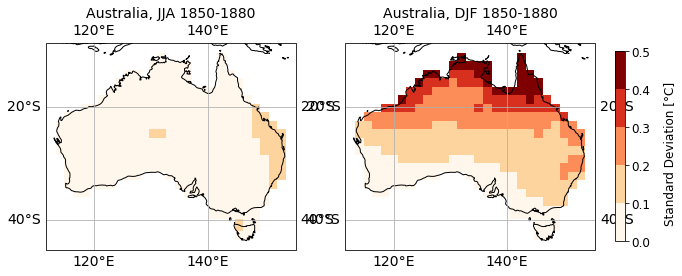

In [53]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
cmax_std = [0,0.5]
label_loc = [2.5, 0.05]
fig = fplot.std_plot(1, 2, std_Aus_pr, cmax_std, titles_Aus, 'OrRd', f'Standard Deviation [{deg}C]', label_loc)

fig.set_figwidth(12)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_std_pr_Aus.pdf', dpi=300, bbox_inches='tight')

## actual figures

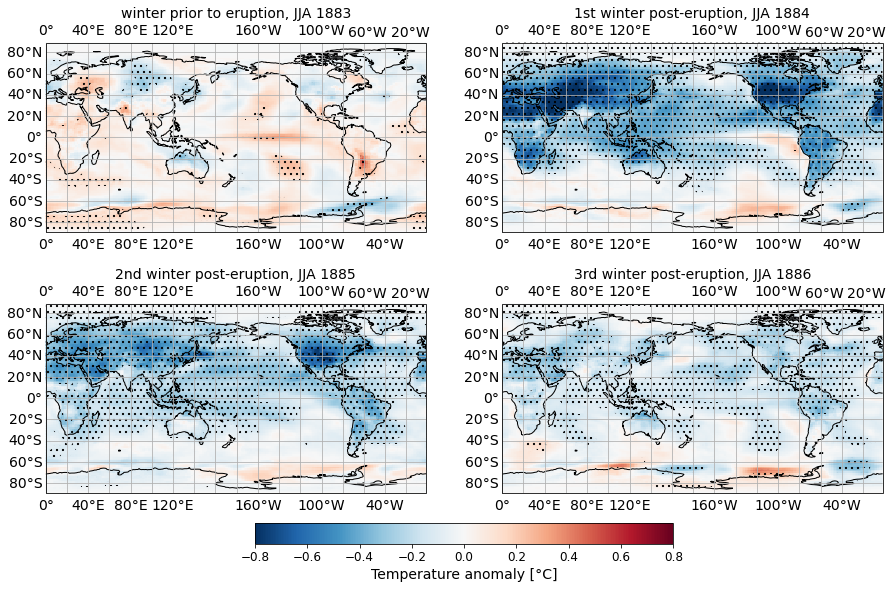

In [37]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Glob.tas.sel(season='JJA'), cmax_tas, K_dates_w, titles_w, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('M_spatial_tas_JJA_Glob.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

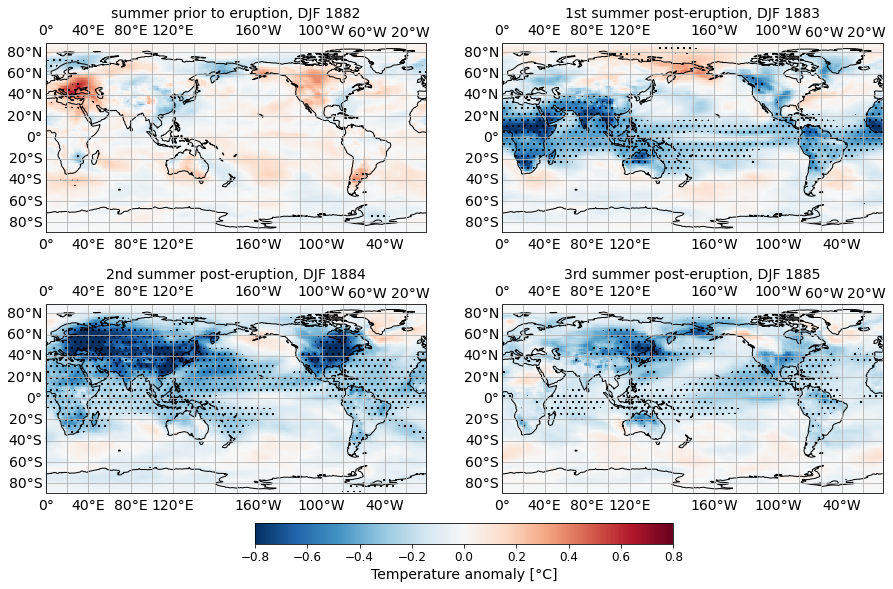

In [38]:
# plot of global seasonal model mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Glob.tas.sel(season='DJF'), cmax_tas, K_dates_w, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('M_spatial_tas_DJF_Glob.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


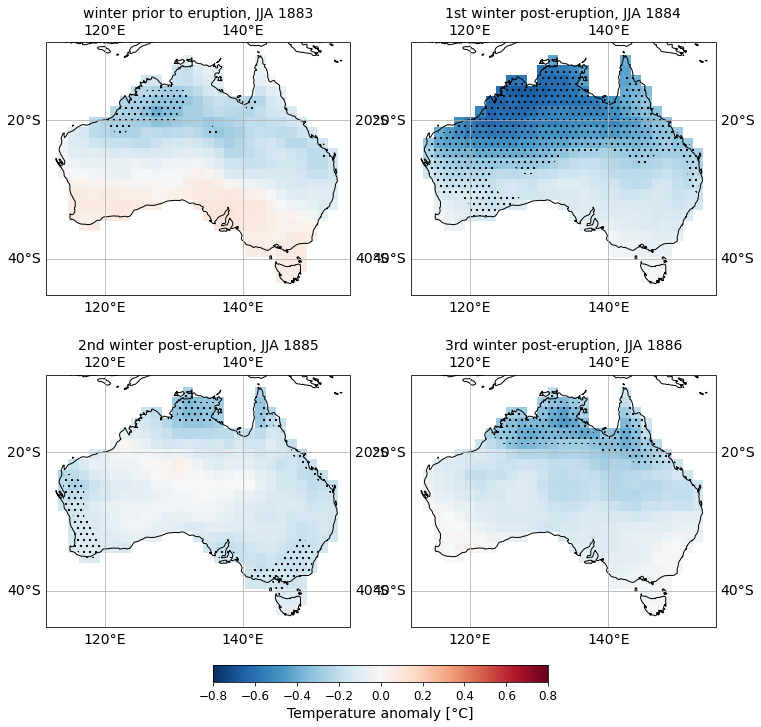

In [44]:
# plot of Australian seasonal model mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Aus.tas.sel(season='JJA'), cmax_tas, K_dates_w, titles_w, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('M_spatial_tas_JJA_Aus.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


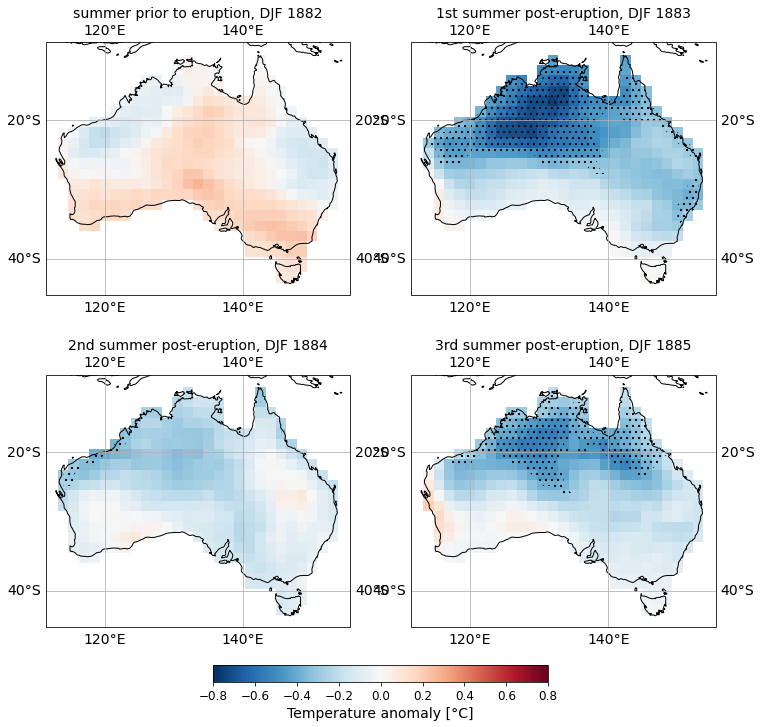

In [39]:
# plot of Australian seasonalmodel mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Aus.tas.sel(season='DJF'), cmax_tas, K_dates_w, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('M_spatial_tas_DJF_Aus.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

In [38]:
# # plot of SH seasonal model mean temperature
# fig = fplot.spatial_plot(2, 2, K_mmm_s_SH.tas.sel(season='DJF'), cmax_tas, K_dates_s, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

# fig.set_figwidth(15)
# fig.set_figheight(8) # these two parameters change the figure height and width 

# plt.savefig('M_spatial_tas_DJF_SH.png', dpi=300)#, bbox_inches='tight')

In [39]:
# # plot of EA seasonal model mean temperature
# fig = fplot.spatial_plot(2, 2, K_mmm_s_EA.tas.sel(season='DJF'), cmax_tas, K_dates_s, titles_s, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

# fig.set_figwidth(15)
# fig.set_figheight(8) # these two parameters change the figure height and width 

# plt.savefig('M_spatial_tas_DJF_EA.png', dpi=300)#, bbox_inches='tight')

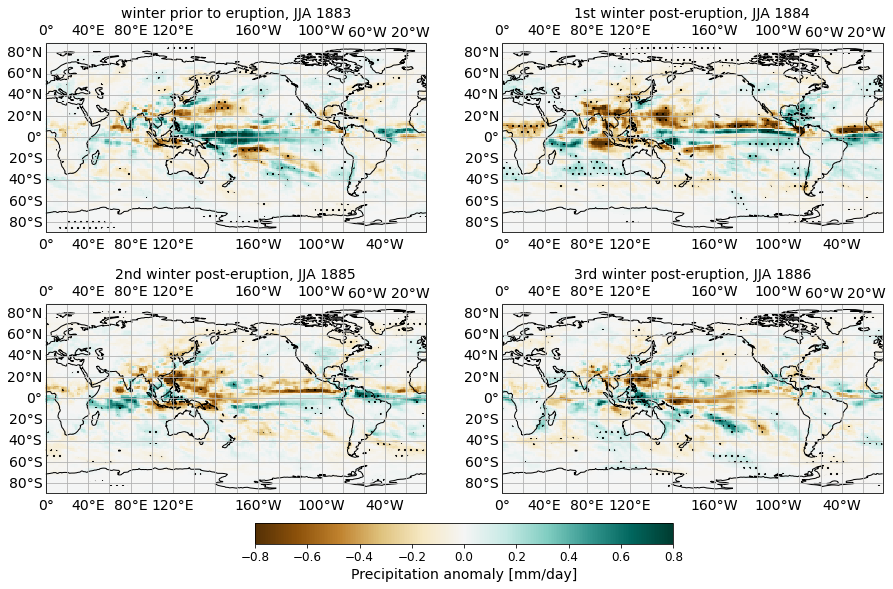

In [40]:
# plot of global seasonal model mean rainfall at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Glob.pr.sel(season='JJA'), cmax_pr, K_dates_w, titles_w, 'BrBG', f'Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('M_spatial_pr_JJA_Glob.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

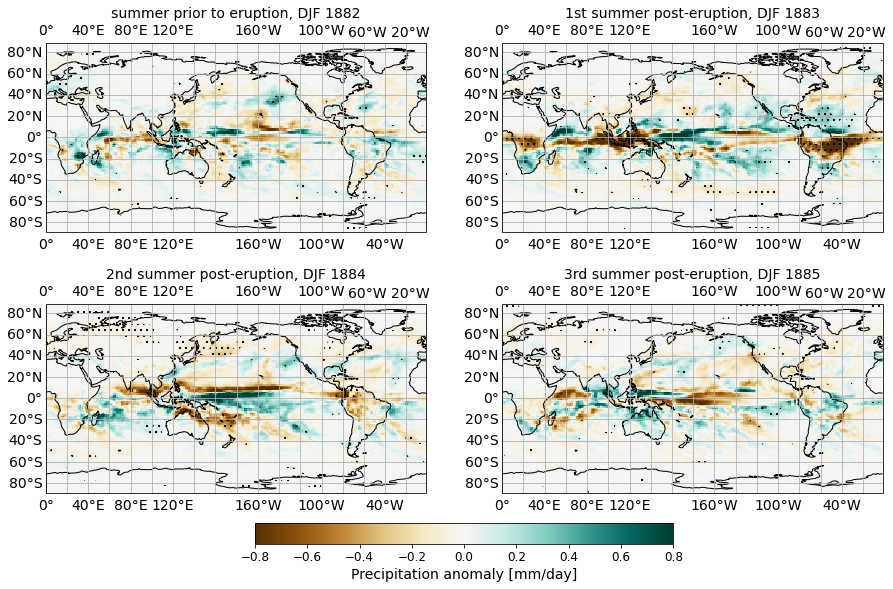

In [41]:
# plot of global seasonal model mean rainfall at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Glob.pr.sel(season='DJF'), cmax_pr, K_dates_w, titles_s, 'BrBG', f'Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('M_spatial_pr_DJF_Glob.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


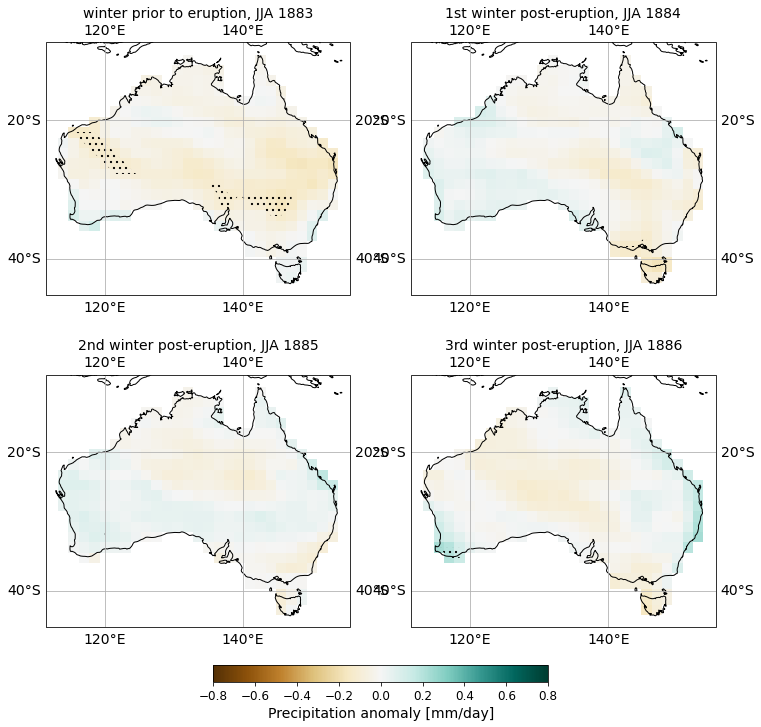

In [42]:
# plot of Australian seasonal model mean rainfall at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Aus.pr.sel(season='JJA'), cmax_pr, K_dates_w, titles_w, 'BrBG', f'Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('M_spatial_pr_JJA_Aus.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


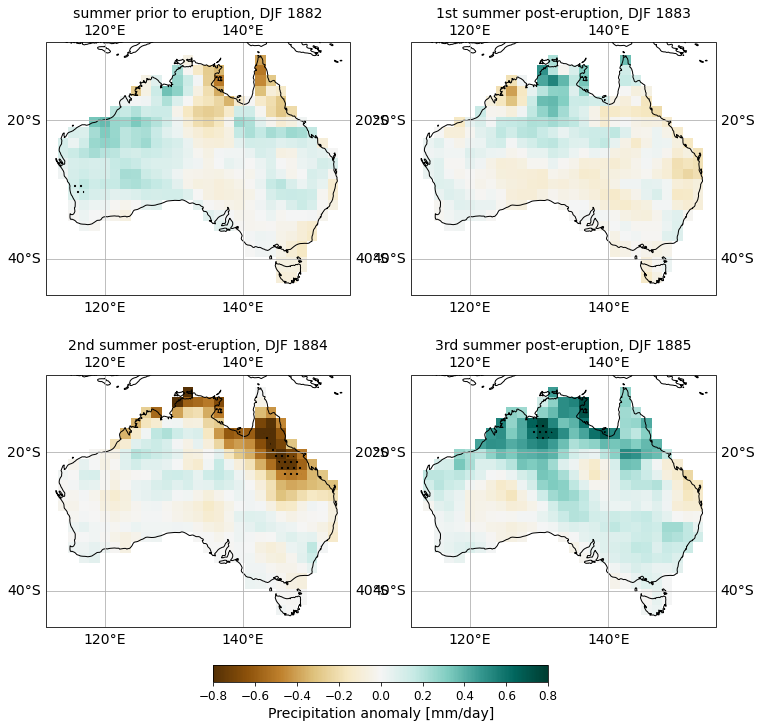

In [43]:
# plot of Australian seasonal model mean rainfall at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_s_Aus.pr.sel(season='DJF'), cmax_pr, K_dates_w, titles_s, 'BrBG', f'Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('M_spatial_pr_DJF_Aus.pdf', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

In [26]:
# take the 5 year clim for years proior to eruption
K_5yrm_glob = K_mmm_s_Glob.sel(seasonyear = slice('1878-08','1883-08')).mean(dim='seasonyear')
K_5yrm_Aus = K_mmm_s_Aus.sel(seasonyear = slice('1878-08','1883-08')).mean(dim='seasonyear')

## 5 year average figures

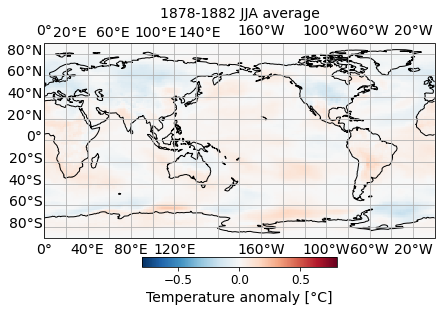

In [31]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tas.sel(season='JJA'), cmax_tas, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_tas_JJA_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

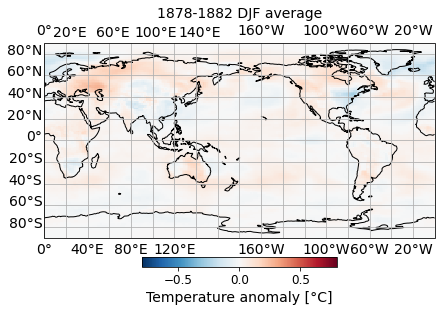

In [32]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.tas.sel(season='DJF'), cmax_tas, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_tas_DJF_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


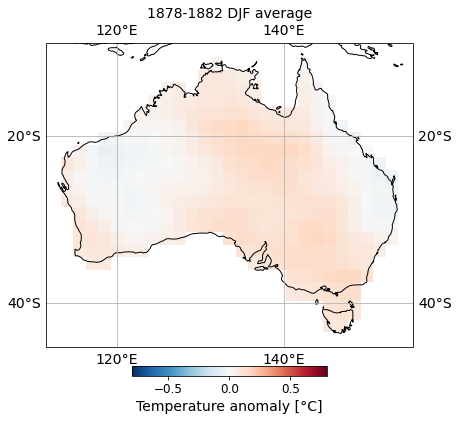

In [33]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.tas.sel(season='DJF'), cmax_tas, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_tas_DJF_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

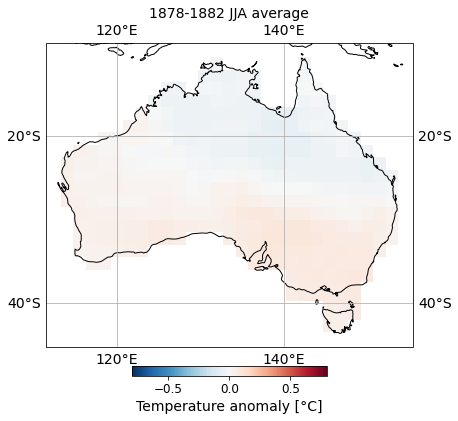

In [34]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.tas.sel(season='JJA'), cmax_tas, 'RdBu_r', f'Temperature anomaly [{deg}C]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_tas_JJA_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

### precipitation

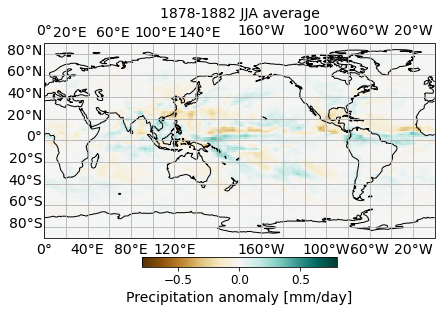

In [37]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.pr.sel(season='JJA'), cmax_pr, 'BrBG', f'Precipitation anomaly [mm/day]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_pr_JJA_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

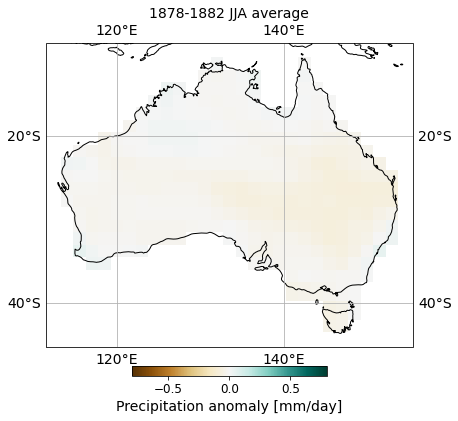

In [38]:
# plot of Australia monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.pr.sel(season='JJA'), cmax_pr, 'BrBG', f'Precipitation anomaly [mm/day]', '1878-1882 JJA average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_pr_JJA_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

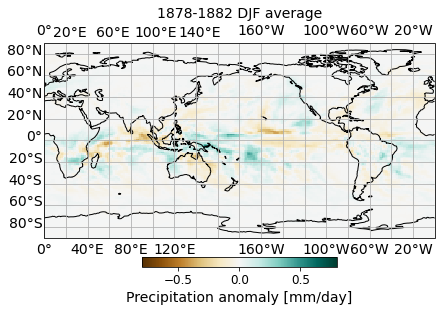

In [39]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_glob.pr.sel(season='DJF'), cmax_pr, 'BrBG', f'Precipitation anomaly [mm/day]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_pr_DJF_Glob.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves

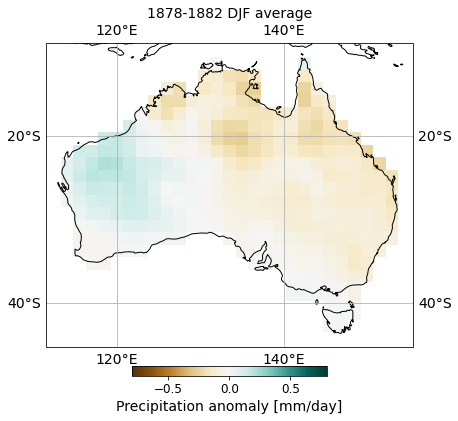

In [40]:
# plot of Australia monthly member mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_clim_plot(K_5yrm_Aus.pr.sel(season='DJF'), cmax_pr, 'BrBG', f'Precipitation anomaly [mm/day]', '1878-1882 DJF average')

fig.set_figwidth(7)
fig.set_figheight(7) # these two parameters change the figure height and width 

plt.savefig('M_spatial_5yrm_pr_DJF_Aus.png', dpi=300, bbox_inches='tight') # bbox=tight removes lat labels when figure saves